# Domestic migration rates

We aim here to generate data files that can be used by the sim to:
- Select who moves within the US
- Determine *where* they move
- Determine *what living arrangments* they move into (GQ vs non-GQ, existing vs non-existing household, relationship within household)

We inform all of this with ACS PUMS.

In [1]:
import pandas as pd, numpy as np
import seaborn as sns
from numpy.random import default_rng
import scipy.stats as stats

pd.set_option('display.min_rows', 20)

! whoami
! date

zmbc
Tue Nov  1 09:17:15 PDT 2022


## Read PUMS and investigate the data

In [2]:
acs = pd.read_hdf('../data/acs_2020_5yr_person.hdf', key='acs')

In [3]:
# Duplicate indices! In the future, should probably deal with this in download_acs!
# Filter to relevant columns to save memory
acs = acs[['SERIALNO', 'MIG', 'MIGSP', 'MIGPUMA', 'RELSHIPP', 'HISP', 'RAC1P', 'AGEP', 'SEX', 'NATIVITY', 'ST', 'PUMA', 'PWGTP']].reset_index(drop=True)

### Define demographics and migration

In [4]:
# Based on code from vivarium_census_prl_synth_pop repository:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L105-L118

LATINO_VAR_MAP = {i: (1 if i == 1 else 0) for i in range(1, 25)}

RACE_ETHNICITY_VAR_MAP = {
    0: "Latino",
    1: "White",
    2: "Black",
    3: "AIAN",
    4: "AIAN",
    5: "AIAN",
    6: "Asian",
    7: "NHOPI",
    8: "Multiracial or Other",
    9: "Multiracial or Other",
}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L99-L106

acs["race_ethnicity"] = acs.HISP.map(LATINO_VAR_MAP)
acs.loc[acs.race_ethnicity == 1, "race_ethnicity"] = acs.loc[
    acs.race_ethnicity == 1
].RAC1P

# label each race/eth
acs.race_ethnicity = acs.race_ethnicity.map(RACE_ETHNICITY_VAR_MAP)

In [5]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/constants/metadata.py#L120

SEX_VAR_MAP = {1: "Male", 2: "Female"}

# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/743db67769bc5969c8326d5fb50840da65ec6387/src/vivarium_census_prl_synth_pop/data/loader.py#L109

acs['sex'] = acs.SEX.map(SEX_VAR_MAP)

In [6]:
acs['age_group'] = pd.cut(acs.AGEP, [0, 15, 18, 19, 20, 21, 22, 25, 30, 40, 50, 60, 70, 80, 100], right=False)

In [7]:
# https://github.com/ihmeuw/vivarium_census_prl_synth_pop/blob/acc34afed6a55484abee0d37452a1cbe10f31b8b/src/vivarium_census_prl_synth_pop/constants/metadata.py#L122-L142
RELATIONSHIP_TO_HOUSEHOLD_HEAD_MAP = {
    20: "Reference person",
    21: "Opp-sex spouse",
    22: "Opp-sex partner",
    23: "Same-sex spouse",
    24: "Same-sex partner",
    25: "Biological child",
    26: "Adopted child",
    27: "Stepchild",
    28: "Sibling",
    29: "Parent",
    30: "Grandchild",
    31: "Parent-in-law",
    32: "Child-in-law",
    33: "Other relative",
    34: "Roommate",
    35: "Foster child",
    36: "Other nonrelative",
    37: "Institutionalized GQ pop",
    38: "Noninstitutionalized GQ pop",
}

acs['relationship'] = acs.RELSHIPP.map(RELATIONSHIP_TO_HOUSEHOLD_HEAD_MAP)

In [8]:
# NOTE: We do not include people who moved from Puerto Rico. We don't include them in international immigration either, so these people are effectively missed.
acs['domestic_migrant'] = (acs.MIG == 3) & (acs.MIGSP != 72)
acs['gq_person'] = acs.RELSHIPP.isin([37, 38])
acs['ref_person'] = (acs.RELSHIPP == 20)

In [9]:
# Percent moving domestically
acs[acs.domestic_migrant].PWGTP.sum() / acs.PWGTP.sum()

0.13069841477356955

<AxesSubplot:>

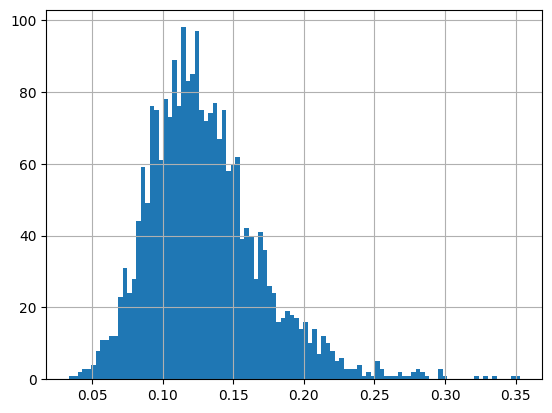

In [10]:
# Distribution of in-movers per capita by destination PUMA
(acs[acs.domestic_migrant].groupby(['ST', 'PUMA']).PWGTP.sum() / acs.groupby(['ST', 'PUMA']).PWGTP.sum()).hist(bins=100)

In [11]:
# Look at high and low PUMAs to migrate to
(acs[acs.domestic_migrant].groupby(['ST', 'PUMA']).PWGTP.sum() / acs.groupby(['ST', 'PUMA']).PWGTP.sum()).sort_values()

ST  PUMA 
6   3743     0.033403
36  3901     0.039678
6   3741     0.040582
36  4010     0.041274
    4008     0.043069
    4009     0.045791
    3208     0.046014
    3205     0.046537
    3204     0.048416
    3203     0.049169
               ...   
53  11603    0.288684
48  501      0.296081
8   803      0.297175
26  2702     0.297401
45  604      0.299595
4   207      0.322796
55  101      0.330082
49  49003    0.335035
12  7301     0.347154
39  4105     0.352791
Name: PWGTP, Length: 2351, dtype: float64

<AxesSubplot:xlabel='PWGTP_tot', ylabel='PWGTP_mig'>

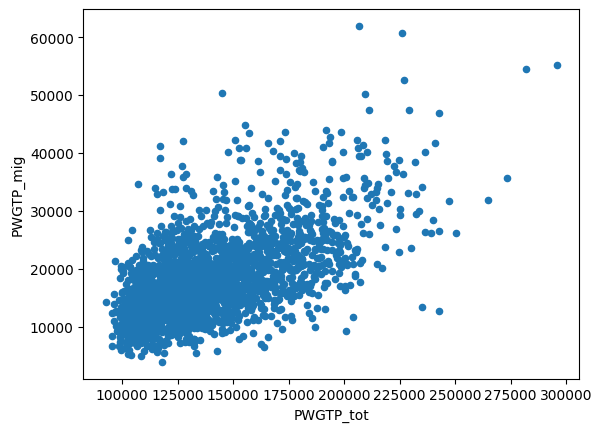

In [12]:
# Relationship between in-movers and population
pd.DataFrame(acs.groupby(['ST', 'PUMA']).PWGTP.sum()).join(acs[acs.domestic_migrant].groupby(['ST', 'PUMA']).PWGTP.sum(), lsuffix='_tot', rsuffix='_mig').plot(kind='scatter', x='PWGTP_tot', y='PWGTP_mig')

In [13]:
# TODO: Move this to where we analyze place
# Looking at our sample size for informing where people move: specifically, how many people from each MIGPUMA
acs[acs.domestic_migrant].groupby(['MIGSP', 'MIGPUMA']).size().sort_values()

MIGSP  MIGPUMA
48.0   6400.0       403
22.0   1600.0       406
54.0   900.0        407
22.0   1900.0       431
24.0   700.0        448
34.0   1700.0       451
13.0   2700.0       455
22.0   2100.0       477
54.0   1300.0       480
35.0   300.0        482
                  ...  
53.0   11600.0    16413
48.0   2300.0     16644
6.0    5900.0     17177
       7300.0     20510
48.0   4600.0     24495
8.0    190.0      26102
25.0   390.0      27032
4.0    100.0      27901
17.0   3400.0     28283
6.0    3700.0     49929
Length: 982, dtype: int64

### Living arrangement

We separate "living arrangement" into two parts: move type and (optionally) relationship.

Move type is into GQ ("gq_person"), starting a new household ("new_household"), moving with a full household ("household"), and joining an existing household ("non_reference_person").

Specifically, these four operations:
- A person moves by themselves into GQ
- A person moves by themselves and establishes a new household
- An entire household of more than one person moves as a unit
- A person moves by themselves and joins an existing household as a non-reference person

These are **not** the only things that can happen in real life.
We do our best to interpret every existing household in ACS as having been created in the last year by some
combination of these operations, and assign each mover one of the types.
Sometimes, this is unlikely: for example, a small household that moved together is fairly likely to be a newly-established
household, not an existing household that moved as-is from somewhere else.
Also, households with multiple non-reference person movers likely happened by a single subfamily moving, rather than
by individuals moving separately.
In these cases, our explanations are unlikely but not clearly false.

However, there is a case that cannot ever be created by these operations:
a household with a reference person who moved with other household members who did not.
We treat this case as if the non-moving members were not there; in other words, as if the moving
reference person had established that household in the last year, even though we know this cannot
be the case.

For two of these move types, relationship is a non-issue: starting a new household, you are always the reference person;
moving with a full household, your relationship attribute is unchanged.

For the remaining two, there is an additional random step where relationship is assigned.
For GQ person moves this is just institutionalized vs non.
For non-reference person moves, this is one of all the many relationship possibilities.

In [14]:
acs = acs.merge(acs[acs.domestic_migrant & acs.ref_person][['SERIALNO', 'MIGPUMA']], on='SERIALNO', suffixes=(None, '_ref_person'), how='left')

In [15]:
# How prevalent is the edge case described above, where they are a moving reference person, and they have non-moving non-reference people in their household?
# As a percentage of ref people who moved
acs[
    acs.ref_person & acs.domestic_migrant &
        (acs.SERIALNO.isin(acs[(~acs.ref_person) & (~acs.domestic_migrant)].SERIALNO.unique()))
].PWGTP.sum() / acs[acs.ref_person & acs.domestic_migrant].PWGTP.sum()

0.13995965562065787

In [16]:
acs[
    acs.ref_person & acs.domestic_migrant &
        (acs.SERIALNO.isin(acs[(~acs.ref_person) & (~acs.domestic_migrant)].SERIALNO.unique()))
]

,SERIALNO,MIG,MIGSP,MIGPUMA,RELSHIPP,HISP,RAC1P,AGEP,SEX,NATIVITY,...,PUMA,PWGTP,race_ethnicity,sex,age_group,relationship,domestic_migrant,gq_person,ref_person,MIGPUMA_ref_person
59,2016000000969,3.0,42.0,300.0,20,1,1,56,1,1,...,300,19,White,Male,"[50, 60)",Reference person,True,False,True,300.0
93,2016000001414,3.0,42.0,1000.0,20,1,1,31,1,1,...,1000,14,White,Male,"[30, 40)",Reference person,True,False,True,1000.0
191,2016000002771,3.0,42.0,3400.0,20,1,1,29,1,2,...,3403,17,White,Male,"[25, 30)",Reference person,True,False,True,3400.0
651,2016000007901,3.0,42.0,3200.0,20,1,2,56,2,1,...,3303,29,Black,Female,"[50, 60)",Reference person,True,False,True,3200.0
726,2016000008725,3.0,42.0,1400.0,20,1,1,23,1,1,...,1400,17,White,Male,"[22, 25)",Reference person,True,False,True,1400.0
923,2016000010879,3.0,42.0,2500.0,20,1,1,71,1,1,...,900,5,White,Male,"[70, 80)",Reference person,True,False,True,2500.0
1437,2016000016772,3.0,42.0,3200.0,20,1,6,25,1,2,...,3209,32,Asian,Male,"[25, 30)",Reference person,True,False,True,3200.0
1844,2016000021356,3.0,42.0,400.0,20,1,1,61,2,1,...,1100,8,White,Female,"[60, 70)",Reference person,True,False,True,400.0
2155,2016000024922,3.0,42.0,2890.0,20,5,1,28,2,1,...,2803,18,Latino,Female,"[25, 30)",Reference person,True,False,True,2890.0
2263,2016000026153,3.0,42.0,800.0,20,1,9,34,2,1,...,802,13,Multiracial or Other,Female,"[30, 40)",Reference person,True,False,True,800.0


In [17]:
acs['move_type'] = np.where(
    acs.domestic_migrant,
    np.where(
        acs.gq_person,
        'gq_person',
        np.where(
            # They founded a new household if:
            # - They are the reference person
            # - Nobody else in the household moved with them (from same place)
            acs.ref_person & acs.SERIALNO.isin(acs[acs.MIGPUMA_ref_person == acs.MIGPUMA].groupby('SERIALNO').size().pipe(lambda x: x[x == 1]).index),
            'new_household',
            # Where the reference person moved from same MIGPUMA, they were part of a household move
            np.where(acs.MIGPUMA_ref_person == acs.MIGPUMA, 'household', 'non_reference_person'),
        ),
    ),
    'none',
)

In [18]:
# Move type distribution (this should not be interpreted as the *number* of moves because household moves affect an entire household unit)
acs[acs.domestic_migrant].groupby('move_type').PWGTP.sum() / acs[acs.domestic_migrant].PWGTP.sum()

move_type
gq_person               0.083051
household               0.585842
new_household           0.151385
non_reference_person    0.179722
Name: PWGTP, dtype: float64

In [19]:
# Relationships within households that moved as a unit
acs[acs.move_type == 'household'].groupby('relationship').PWGTP.sum().sort_values()

relationship
Foster child           16205
Child-in-law           39923
Parent-in-law          49937
Same-sex spouse        60812
Same-sex partner       64890
Adopted child         154954
Other relative        252486
Grandchild            269683
Parent                274521
Sibling               311578
Other nonrelative     387900
Stepchild             407967
Roommate              881921
Opp-sex partner      1254514
Opp-sex spouse       4423417
Biological child     7754638
Reference person     8399611
Name: PWGTP, dtype: int64

In [20]:
# GQ person mover relationship distribution
# This really surprises me! I would have expected way less institutionalized moving.
# This is a case where it might have a lot to do with the "where" part, i.e. distance.
acs[acs.move_type == 'gq_person'].groupby('relationship').PWGTP.sum().sort_values()

relationship
Institutionalized GQ pop       1545402
Noninstitutionalized GQ pop    1999399
Name: PWGTP, dtype: int64

In [21]:
# non-reference person mover relationship distribution
acs[acs.move_type == 'non_reference_person'].groupby('relationship').PWGTP.sum().sort_values()

relationship
Same-sex spouse        15736
Same-sex partner       40863
Adopted child          63257
Foster child           66238
Parent-in-law          88071
Child-in-law          198920
Stepchild             222725
Parent                236299
Sibling               321585
Opp-sex spouse        447649
Other relative        509204
Grandchild            676951
Opp-sex partner       739625
Other nonrelative     895649
Roommate             1306774
Biological child     1841344
Name: PWGTP, dtype: int64

<AxesSubplot:>

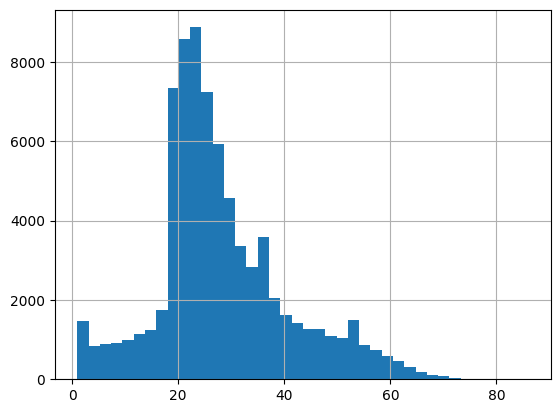

In [22]:
# Looking at the relationship between demographics and relationship in new household -- specifically, age for biological children
acs[(acs.move_type == 'non_reference_person') & (acs.relationship == 'Biological child')].AGEP.hist(bins=40)

In [23]:
# An example household with a biological child mover -- we see here that they also brought their spouse, which we won't be able to capture (subfamily structure) unless it happens by astronomical luck
acs[acs.SERIALNO == acs[(acs.move_type == 'non_reference_person') & (acs.relationship == 'Biological child')].SERIALNO.sample(1, random_state=np.random.RandomState(1234)).iloc[0]]

,SERIALNO,MIG,MIGSP,MIGPUMA,RELSHIPP,HISP,RAC1P,AGEP,SEX,NATIVITY,...,PWGTP,race_ethnicity,sex,age_group,relationship,domestic_migrant,gq_person,ref_person,MIGPUMA_ref_person,move_type
1786233,2017001260783,1.0,NaN,NaN,20,1,1,57,2,1,...,14,White,Female,"[50, 60)",Reference person,False,False,True,NaN,none
1786234,2017001260783,1.0,NaN,NaN,21,1,1,65,1,1,...,14,White,Male,"[60, 70)",Opp-sex spouse,False,False,False,NaN,none
1786235,2017001260783,3.0,48.0,5400.0,25,1,1,30,2,1,...,21,White,Female,"[30, 40)",Biological child,True,False,False,NaN,non_reference_person
1786236,2017001260783,NaN,NaN,NaN,30,1,1,0,1,1,...,12,White,Male,"[0, 15)",Grandchild,False,False,False,NaN,none
1786237,2017001260783,3.0,48.0,5400.0,32,1,1,29,1,1,...,15,White,Male,"[25, 30)",Child-in-law,True,False,False,NaN,non_reference_person


## Rates of move types by demographics

In [24]:
def display_migration_rates(migration_rates, name):
    migration_rates = migration_rates.rename(name).reset_index()
    migration_rates[['age_start', 'age_end']] = [[x.left, x.right] for x in migration_rates['age_group']]
    migration_rates['age'] = np.average(migration_rates[['age_start', 'age_end']], axis=1)
    
    sns.relplot(
        data=migration_rates,
        x="age", y=name,
        hue="race_ethnicity",
        col="sex",
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )

In [25]:
def format_migration_rates_for_file(migration_rates, name):
    migration_rates = migration_rates.rename(name).reset_index()
    age_bound_cols = ['age_start', 'age_end']
    migration_rates[age_bound_cols] = [[x.left, x.right] for x in migration_rates['age_group']]
    migration_rates = migration_rates.drop(columns=['age_group']).rename(columns={'ST': 'state', 'PUMA': 'puma'})
    return migration_rates[age_bound_cols + [c for c in migration_rates.columns if c not in age_bound_cols]]

In [26]:
def display_sample_size(acs_df, move_type, stratification_columns=['age_group', 'sex', 'race_ethnicity'], col_suffix=''):
    acs_subset = acs_df[acs_df.domestic_migrant & (acs_df.move_type == move_type)]
    sample_size = acs_subset.groupby([col + col_suffix for col in stratification_columns]).size().rename('sample_size').reset_index()
    sample_size[['age_start', 'age_end']] = [[x.left, x.right] for x in sample_size['age_group' + col_suffix]]
    sample_size['age'] = np.average(sample_size[['age_start', 'age_end']], axis=1)

    g = sns.relplot(
        data=sample_size,
        x="age", y="sample_size",
        hue="race_ethnicity" + col_suffix,
        col="sex" + col_suffix,
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )
    g.set(yscale="symlog")
    g.set(ylim=(0, None))
    return g

In [27]:
def format_migration_rates_for_file(migration_rates, name):
    if isinstance(migration_rates, pd.Series):
        migration_rates = migration_rates.rename(name).reset_index()
    else:
        migration_rates = migration_rates.reset_index()
    age_bound_cols = ['age_start', 'age_end']
    migration_rates[age_bound_cols] = [[x.left, x.right] for x in migration_rates['age_group']]
    migration_rates = migration_rates.drop(columns=['age_group']).rename(columns={'ST': 'state', 'PUMA': 'puma'})
    return migration_rates[age_bound_cols + [c for c in migration_rates.columns if c not in age_bound_cols]]

### Household moves

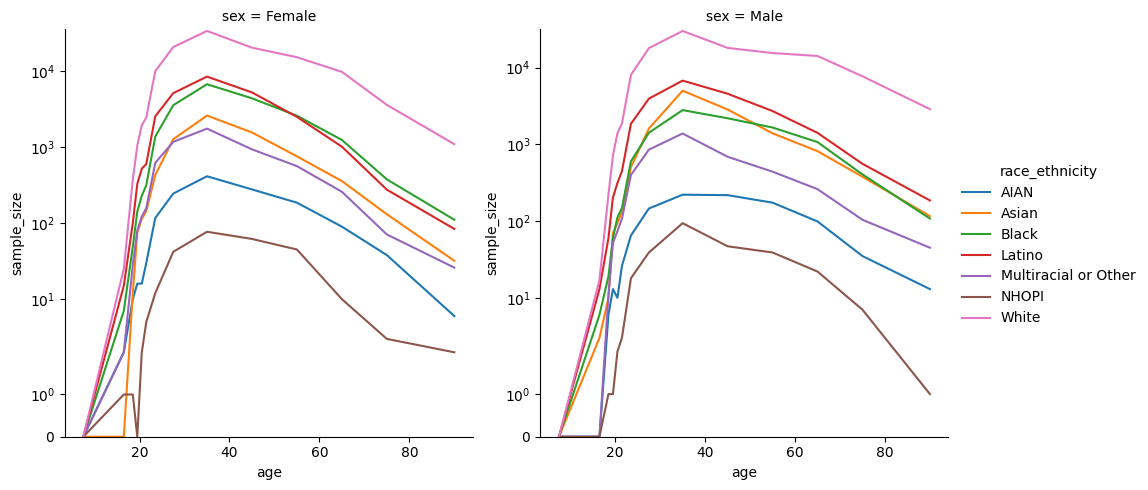

In [28]:
display_sample_size(acs[acs.ref_person], 'household')

In [154]:
hh_move_rates = (
    acs[acs.ref_person & (acs.move_type == 'household')].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum() /
        acs[(acs.ref_person) & (acs.SERIALNO.isin(acs.groupby('SERIALNO').size().pipe(lambda x: x[x > 1]).index))].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum()
)
hh_move_rates

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                         NaN
                   Asian                        NaN
                   Black                        NaN
                   Latino                       NaN
                   Multiracial or Other         NaN
                   NHOPI                        NaN
                   White                        NaN
           Male    AIAN                         NaN
                   Asian                        NaN
                   Black                        NaN
                                             ...   
[80, 100)  Female  Multiracial or Other    0.026681
                   NHOPI                   0.010601
                   White                   0.024590
           Male    AIAN                    0.016338
                   Asian                   0.030044
                   Black                   0.016109
                   Latino                  0.025954
                   Multi

In [155]:
len(hh_move_rates[hh_move_rates.isnull()])

14

In [156]:
len(hh_move_rates[hh_move_rates == np.inf])

0

In [157]:
len(hh_move_rates[hh_move_rates == 0])

5

In [158]:
hh_move_rates = hh_move_rates.replace(np.inf, np.nan).fillna(hh_move_rates.median())
hh_move_rates.sort_values()

age_group  sex     race_ethnicity      
[15, 18)   Male    AIAN                    0.000000
[19, 20)   Female  NHOPI                   0.000000
[15, 18)   Female  Asian                   0.000000
           Male    NHOPI                   0.000000
                   Multiracial or Other    0.000000
[80, 100)  Female  NHOPI                   0.010601
                   AIAN                    0.012650
                   Latino                  0.014463
[70, 80)   Female  NHOPI                   0.015147
[80, 100)  Female  Black                   0.015185
                                             ...   
[19, 20)   Female  White                   0.439462
           Male    Multiracial or Other    0.440199
[18, 19)   Female  White                   0.445785
[19, 20)   Female  Multiracial or Other    0.449700
[18, 19)   Female  Multiracial or Other    0.516464
           Male    AIAN                    0.539652
           Female  AIAN                    0.628049
           Male    NHOPI

In [159]:
assert (
    len(hh_move_rates) ==
        hh_move_rates.index.get_level_values('age_group').nunique() * hh_move_rates.index.get_level_values('sex').nunique() * hh_move_rates.index.get_level_values('race_ethnicity').nunique()
)

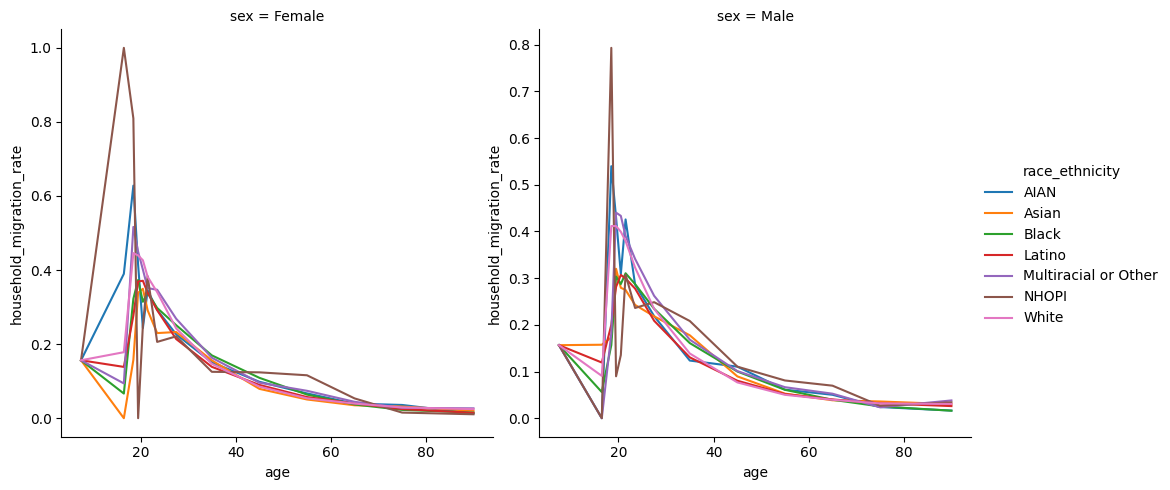

In [160]:
display_migration_rates(hh_move_rates, 'household_migration_rate')

In [161]:
format_migration_rates_for_file(hh_move_rates, 'household_domestic_migration_rate').to_csv('sim_inputs/household_domestic_migration_rates.csv', index=False)

### Person-level rates
#### GQ person

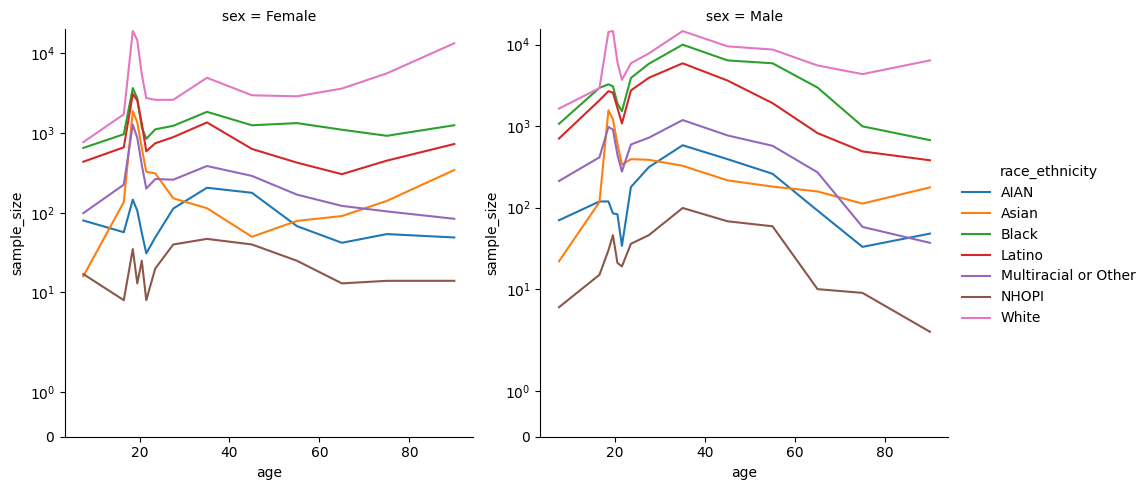

In [37]:
display_sample_size(acs, 'gq_person')

In [38]:
gq_person_migration_rates = (
    acs[acs.move_type == 'gq_person'].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum() /
        acs.groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum()
)
gq_person_migration_rates

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                    0.002394
                   Asian                   0.000074
                   Black                   0.001307
                   Latino                  0.000381
                   Multiracial or Other    0.000471
                   NHOPI                   0.002340
                   White                   0.000340
           Male    AIAN                    0.002209
                   Asian                   0.000035
                   Black                   0.001867
                                             ...   
[80, 100)  Female  Multiracial or Other    0.008364
                   NHOPI                   0.015128
                   White                   0.020082
           Male    AIAN                    0.022176
                   Asian                   0.007225
                   Black                   0.019369
                   Latino                  0.008555
                   Multi

In [39]:
len(gq_person_migration_rates[gq_person_migration_rates.isnull()])

0

In [40]:
len(gq_person_migration_rates[gq_person_migration_rates == np.inf])

0

In [41]:
len(gq_person_migration_rates[gq_person_migration_rates == 0])

0

In [42]:
gq_person_migration_rates = gq_person_migration_rates.replace(np.inf, np.nan).fillna(gq_person_migration_rates.median())
gq_person_migration_rates.sort_values()

age_group  sex     race_ethnicity      
[0, 15)    Male    Asian                   0.000035
           Female  Asian                   0.000074
                   White                   0.000340
                   Latino                  0.000381
[40, 50)   Female  Asian                   0.000383
[0, 15)    Female  Multiracial or Other    0.000471
           Male    Latino                  0.000607
                   White                   0.000672
[60, 70)   Female  Asian                   0.000688
[0, 15)    Male    NHOPI                   0.000693
                                             ...   
[19, 20)   Male    Asian                   0.132777
[18, 19)   Female  Black                   0.135829
           Male    White                   0.145517
           Female  Multiracial or Other    0.149349
[19, 20)   Female  Asian                   0.152900
           Male    White                   0.159538
           Female  White                   0.161300
[18, 19)   Male    Asian

In [43]:
assert (
    len(gq_person_migration_rates) ==
        gq_person_migration_rates.index.get_level_values('age_group').nunique() * gq_person_migration_rates.index.get_level_values('sex').nunique() * gq_person_migration_rates.index.get_level_values('race_ethnicity').nunique()
)

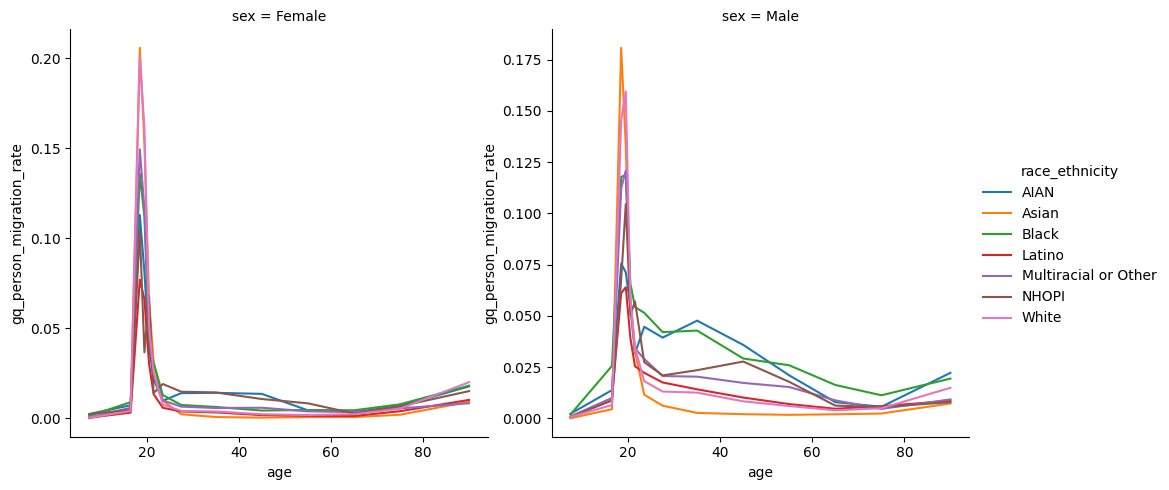

In [44]:
display_migration_rates(gq_person_migration_rates, 'gq_person_migration_rate')

In [45]:
format_migration_rates_for_file(gq_person_migration_rates, 'gq_person_migration_rate')

,age_start,age_end,sex,race_ethnicity,gq_person_migration_rate
0,0,15,Female,AIAN,0.002394
1,0,15,Female,Asian,0.000074
2,0,15,Female,Black,0.001307
3,0,15,Female,Latino,0.000381
4,0,15,Female,Multiracial or Other,0.000471
5,0,15,Female,NHOPI,0.002340
6,0,15,Female,White,0.000340
7,0,15,Male,AIAN,0.002209
8,0,15,Male,Asian,0.000035
9,0,15,Male,Black,0.001867


#### New household

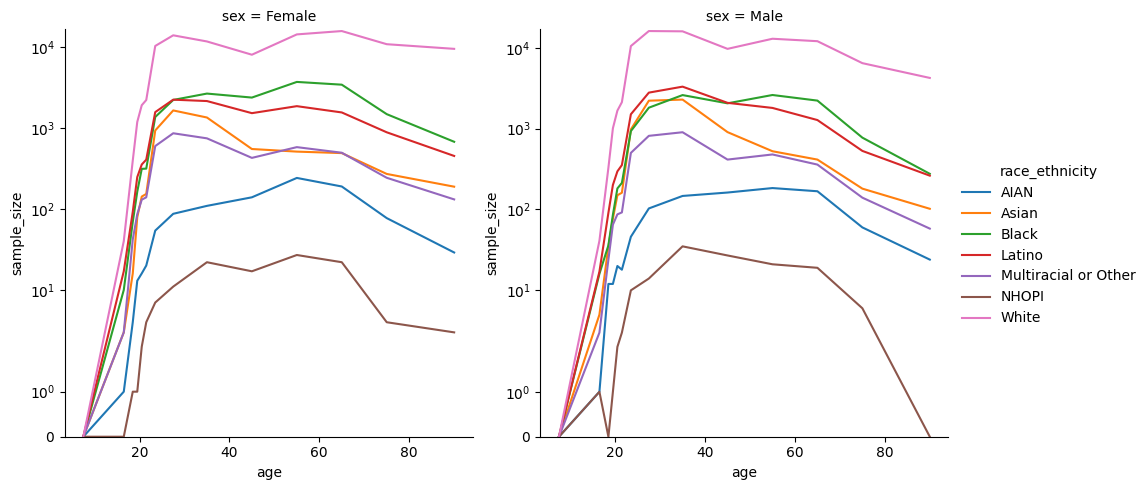

In [46]:
display_sample_size(acs, 'new_household')

In [47]:
new_household_migration_rates = (
    acs[acs.move_type == 'new_household'].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum() /
        acs.groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum()
)
new_household_migration_rates

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                    0.000000
                   Asian                   0.000000
                   Black                   0.000000
                   Latino                  0.000000
                   Multiracial or Other    0.000000
                   NHOPI                   0.000000
                   White                   0.000000
           Male    AIAN                    0.000000
                   Asian                   0.000000
                   Black                   0.000000
                                             ...   
[80, 100)  Female  Multiracial or Other    0.034615
                   NHOPI                   0.006082
                   White                   0.032790
           Male    AIAN                    0.022119
                   Asian                   0.012188
                   Black                   0.016119
                   Latino                  0.014895
                   Multi

In [48]:
len(new_household_migration_rates[new_household_migration_rates.isnull()])

0

In [49]:
len(new_household_migration_rates[new_household_migration_rates == np.inf])

0

In [50]:
len(new_household_migration_rates[new_household_migration_rates == 0])

17

In [51]:
new_household_migration_rates = new_household_migration_rates.replace(np.inf, np.nan).fillna(new_household_migration_rates.median())
new_household_migration_rates.sort_values()

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                    0.000000
[80, 100)  Male    NHOPI                   0.000000
[15, 18)   Female  NHOPI                   0.000000
[0, 15)    Male    White                   0.000000
                   NHOPI                   0.000000
                   Multiracial or Other    0.000000
                   Latino                  0.000000
                   Black                   0.000000
[18, 19)   Male    NHOPI                   0.000000
[0, 15)    Male    AIAN                    0.000000
                                             ...   
[22, 25)   Male    Multiracial or Other    0.058435
[25, 30)   Female  Multiracial or Other    0.058604
           Male    White                   0.059463
[22, 25)   Female  Asian                   0.060213
           Male    Asian                   0.063069
[25, 30)   Male    Multiracial or Other    0.064363
[22, 25)   Female  Multiracial or Other    0.066200
           Male    White

In [52]:
assert (
    len(new_household_migration_rates) ==
        new_household_migration_rates.index.get_level_values('age_group').nunique() * new_household_migration_rates.index.get_level_values('sex').nunique() * new_household_migration_rates.index.get_level_values('race_ethnicity').nunique()
)

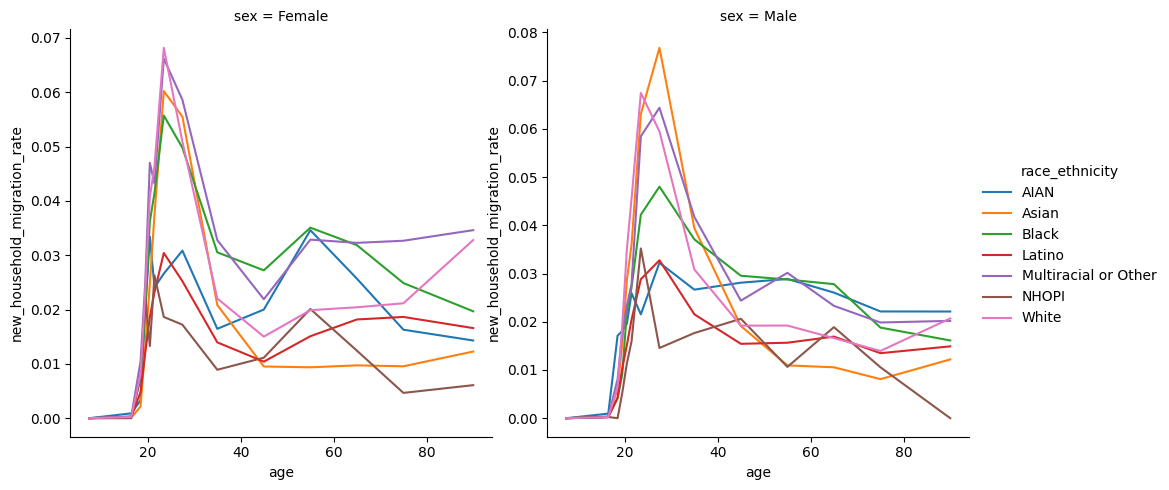

In [53]:
display_migration_rates(new_household_migration_rates, 'new_household_migration_rate')

In [54]:
format_migration_rates_for_file(new_household_migration_rates, 'new_household_migration_rate')

,age_start,age_end,sex,race_ethnicity,new_household_migration_rate
0,0,15,Female,AIAN,0.000000
1,0,15,Female,Asian,0.000000
2,0,15,Female,Black,0.000000
3,0,15,Female,Latino,0.000000
4,0,15,Female,Multiracial or Other,0.000000
5,0,15,Female,NHOPI,0.000000
6,0,15,Female,White,0.000000
7,0,15,Male,AIAN,0.000000
8,0,15,Male,Asian,0.000000
9,0,15,Male,Black,0.000000


#### Non-reference person

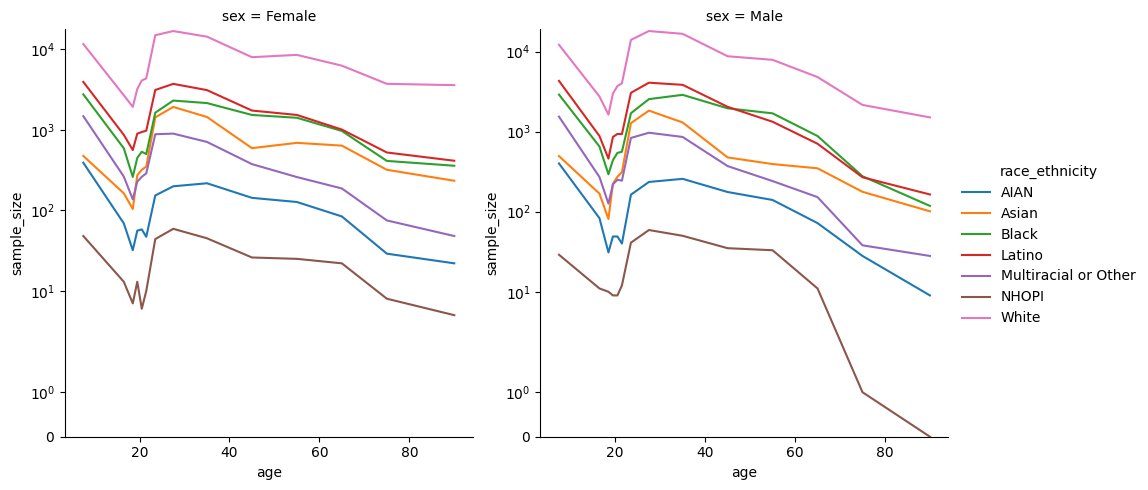

In [55]:
display_sample_size(acs, 'non_reference_person')

In [56]:
non_reference_person_migration_rates = (
    acs[acs.move_type == 'non_reference_person'].groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum() /
        acs.groupby(['age_group', 'sex', 'race_ethnicity']).PWGTP.sum()
)
non_reference_person_migration_rates

age_group  sex     race_ethnicity      
[0, 15)    Female  AIAN                    0.025418
                   Asian                   0.007254
                   Black                   0.019006
                   Latino                  0.012993
                   Multiracial or Other    0.019056
                   NHOPI                   0.014801
                   White                   0.015810
           Male    AIAN                    0.023948
                   Asian                   0.007798
                   Black                   0.019687
                                             ...   
[80, 100)  Female  Multiracial or Other    0.015190
                   NHOPI                   0.020898
                   White                   0.011476
           Male    AIAN                    0.008467
                   Asian                   0.012989
                   Black                   0.008201
                   Latino                  0.012047
                   Multi

In [57]:
len(non_reference_person_migration_rates[non_reference_person_migration_rates.isnull()])

0

In [58]:
len(non_reference_person_migration_rates[non_reference_person_migration_rates == np.inf])

0

In [59]:
len(non_reference_person_migration_rates[non_reference_person_migration_rates == 0])

1

In [60]:
non_reference_person_migration_rates = non_reference_person_migration_rates.replace(np.inf, np.nan).fillna(non_reference_person_migration_rates.median())
non_reference_person_migration_rates.sort_values()

age_group  sex     race_ethnicity      
[80, 100)  Male    NHOPI                   0.000000
[70, 80)   Male    NHOPI                   0.001693
                   White                   0.005050
                   AIAN                    0.005717
                   Multiracial or Other    0.007234
[0, 15)    Female  Asian                   0.007254
[80, 100)  Male    White                   0.007289
[60, 70)   Male    White                   0.007326
[70, 80)   Female  White                   0.007509
                   Black                   0.007745
                                             ...   
[21, 22)   Female  Multiracial or Other    0.091332
[20, 21)   Female  White                   0.091466
[22, 25)   Male    NHOPI                   0.092706
[20, 21)   Female  Multiracial or Other    0.093170
[22, 25)   Male    White                   0.094790
[21, 22)   Female  White                   0.095959
[22, 25)   Female  Multiracial or Other    0.096415
           Male    Multi

In [61]:
assert (
    len(non_reference_person_migration_rates) ==
        non_reference_person_migration_rates.index.get_level_values('age_group').nunique() * non_reference_person_migration_rates.index.get_level_values('sex').nunique() * non_reference_person_migration_rates.index.get_level_values('race_ethnicity').nunique()
)

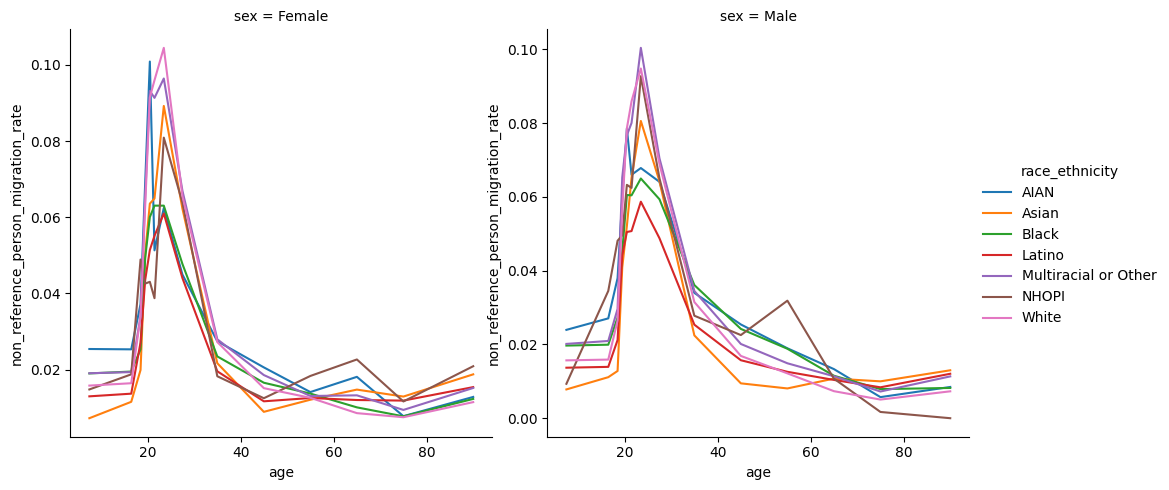

In [62]:
display_migration_rates(non_reference_person_migration_rates, 'non_reference_person_migration_rate')

In [63]:
format_migration_rates_for_file(non_reference_person_migration_rates, 'non_reference_person_migration_rate')

,age_start,age_end,sex,race_ethnicity,non_reference_person_migration_rate
0,0,15,Female,AIAN,0.025418
1,0,15,Female,Asian,0.007254
2,0,15,Female,Black,0.019006
3,0,15,Female,Latino,0.012993
4,0,15,Female,Multiracial or Other,0.019056
5,0,15,Female,NHOPI,0.014801
6,0,15,Female,White,0.015810
7,0,15,Male,AIAN,0.023948
8,0,15,Male,Asian,0.007798
9,0,15,Male,Black,0.019687


In [64]:
rates_for_file = pd.DataFrame(gq_person_migration_rates.rename('gq_person_migration_rate'))\
    .join(new_household_migration_rates.rename('new_household_migration_rate'))\
    .join(non_reference_person_migration_rates.rename('non_reference_person_migration_rate'))\
    .pipe(lambda x: format_migration_rates_for_file(x, None))
rates_for_file.to_csv('sim_inputs/individual_domestic_migration_rates.csv')
rates_for_file

,age_start,age_end,sex,race_ethnicity,gq_person_migration_rate,new_household_migration_rate,non_reference_person_migration_rate
0,0,15,Female,AIAN,0.002394,0.000000,0.025418
1,0,15,Female,Asian,0.000074,0.000000,0.007254
2,0,15,Female,Black,0.001307,0.000000,0.019006
3,0,15,Female,Latino,0.000381,0.000000,0.012993
4,0,15,Female,Multiracial or Other,0.000471,0.000000,0.019056
5,0,15,Female,NHOPI,0.002340,0.000000,0.014801
6,0,15,Female,White,0.000340,0.000000,0.015810
7,0,15,Male,AIAN,0.002209,0.000000,0.023948
8,0,15,Male,Asian,0.000035,0.000000,0.007798
9,0,15,Male,Black,0.001867,0.000000,0.019687


## Relationship, for applicable move types

In [167]:
# Copied from VEHSS, where I did a lot of the same thinking
# https://github.com/ihmeuw/vehss/blob/8f5db275393f8ff9906010a9214e10f4aec71a2b/vehss/utils.py#L119
def merge(df1, df2, on, *args, **kwargs):
    """
    Like df1.merge(df2, on=on, *args, **kwargs), except:
    1. If on is empty, all rows are considered to match (a Cartesian product).
    """
    if len(on) > 0:
        return df1.merge(df2, on=on, *args, **kwargs)

    # Apparently the best way to do this in Pandas
    # https://stackoverflow.com/a/46895905/
    df1 = df1.copy()
    df2 = df2.copy()
    df1['key'] = 0
    df2['key'] = 0
    return df1.merge(df2, on='key', *args, **kwargs).drop(columns=['key'])

def diff_dfs(df1, df2):
    """
    Returns rows not in common between two DataFrames.
    """
    assert len(df1) == len(df1.drop_duplicates())
    assert len(df2) == len(df2.drop_duplicates())
    return pd.concat([df1, df2]).drop_duplicates(keep=False)

def expand_index_to(df, index, any_match=True, full_match=True):
    """
    Changes a df to have a specified index, assuming that the df's index already contains
    some of the index's levels, by duplicating the rows that match on the subset it already
    contains.
    If full_match is True, the desired index must include everything already in the index.
    """
    # First, do some checks
    # Current and desired index have at least one column in common
    common_columns = [c for c in df.index.names if c in index.names]
    if any_match:
        assert len(common_columns) > 0
    if full_match:
        assert len(common_columns) == len(df.index.names)
    # Current and desired index are both unique and have all the same
    # values in the overlapping columns
    assert np.all(~df.index.duplicated())
    assert np.all(~index.duplicated())
    index_as_df = index.to_frame(index=False)
    df_index_as_df = df.index.to_frame(index=False)
    if any_match:
        assert len(diff_dfs(index_as_df[common_columns].drop_duplicates(), df_index_as_df[common_columns].drop_duplicates())) == 0

    return merge(index_as_df, df.reset_index(), on=common_columns, validate='m:1' if full_match else 'm:m')\
        .set_index(index.names)

In [168]:
def proportions_by_columns(acs_subset, stratification_columns, proportion_columns):
    return (
        acs_subset.groupby(stratification_columns + proportion_columns).PWGTP.sum() /
            acs_subset.groupby(stratification_columns).PWGTP.sum()
    )

In [169]:
def fill_proportions_by_sample_size(acs_subset, stratification_columns, proportion_columns, min_stratification_columns=1, min_distributed=0.05, sample_size_threshold=30):
    working_sample_size = acs_subset.groupby(stratification_columns + proportion_columns).size()
    working_proportions = proportions_by_columns(acs_subset, stratification_columns, proportion_columns)
    full_index = working_proportions.groupby(stratification_columns).sum().index

    less_stratification_columns = stratification_columns[:-1]
    # This cannot handle the min_stratification_columns == 0 case, because Pandas' built-in groupby does not allow
    # an empty list.
    while len(less_stratification_columns) >= min_stratification_columns:
        distribute_by = proportions_by_columns(acs_subset, less_stratification_columns, proportion_columns) #relationship_proportions(acs, move_type, less_stratification_columns)

        # If there is nobody even in the less-granular aggregation, we fill in with a uniform distribution
        distribute_by = distribute_by.where(distribute_by.groupby(less_stratification_columns).sum() > 0, 1 / distribute_by.groupby(less_stratification_columns).size())
        assert np.all(distribute_by.groupby(less_stratification_columns).sum() == 1)

        distributed_all = expand_index_to(distribute_by, working_proportions.index).PWGTP.sort_index()
        assert np.all(distributed_all.groupby(stratification_columns).sum() == 1)

        other_to_distribute = 1 - working_proportions[working_sample_size >= sample_size_threshold].groupby(stratification_columns).sum().reindex(full_index, fill_value=0)
        # Do not distribute 'other' to the categories not in 'other'
        distributed_other = distributed_all.where(working_sample_size < sample_size_threshold, 0)
        distributed_other *= other_to_distribute / distributed_other.groupby(stratification_columns).sum().replace(0, 1)
        assert np.allclose(distributed_other.groupby(stratification_columns).sum(), other_to_distribute)
        
        working_proportions = working_proportions.where(working_sample_size >= 30, distributed_other)
        assert np.allclose(working_proportions.groupby(stratification_columns).sum(), 1)
        assert np.all(working_proportions.notnull())

        all_to_distribute = (min_distributed - other_to_distribute).clip(lower=0)
        distributed_all *= all_to_distribute
        assert np.allclose(distributed_all.groupby(stratification_columns).sum(), all_to_distribute)
        
        working_proportions = ((1 - all_to_distribute) * working_proportions) + distributed_all
        assert np.allclose(working_proportions.groupby(stratification_columns).sum(), 1)
        assert np.all(working_proportions.notnull())

        working_sample_size = working_sample_size.where(working_sample_size >= 30, expand_index_to(working_sample_size.groupby(less_stratification_columns + proportion_columns).sum(), working_sample_size.index)[0])

        less_stratification_columns.pop()

    return working_proportions, working_sample_size

In [170]:
def relationship_proportions(acs, move_type, stratification_columns):
    return (
        acs[acs.move_type == move_type].groupby(stratification_columns + ['relationship']).PWGTP.sum() /
            acs[acs.move_type == move_type].groupby(stratification_columns).PWGTP.sum()
    )

In [171]:
def display_relationship_proportions(relationship_proportions, name):
    relationship_proportions = relationship_proportions.rename(name).reset_index()
    relationship_proportions[['age_start', 'age_end']] = [[x.left, x.right] for x in relationship_proportions['age_group']]
    relationship_proportions['age'] = np.average(relationship_proportions[['age_start', 'age_end']], axis=1)
    
    sns.relplot(
        data=relationship_proportions,
        x="age", y=name,
        hue="race_ethnicity",
        col="sex",
        row="relationship",
        kind="line",
        facet_kws={'sharey': False, 'sharex': True}
    )

In [172]:
def format_relationship_proportions_for_file(relationship_proportions, name):
    if isinstance(relationship_proportions, pd.Series):
        relationship_proportions = relationship_proportions.rename(name).reset_index()
    else:
        relationship_proportions = relationship_proportions.reset_index()
    age_bound_cols = ['age_start', 'age_end']
    relationship_proportions[age_bound_cols] = [[x.left, x.right] for x in relationship_proportions['age_group']]
    relationship_proportions = relationship_proportions.drop(columns=['age_group']).rename(columns={'ST': 'state', 'PUMA': 'puma'})
    return relationship_proportions[age_bound_cols + [c for c in relationship_proportions.columns if c not in age_bound_cols]]

### GQ type

In [71]:
gq_relationship_proportions, gq_sample_size = fill_proportions_by_sample_size(acs[acs.move_type == 'gq_person'], ['age_group', 'sex', 'race_ethnicity'], ['relationship'], min_stratification_columns=1)
gq_relationship_proportions

> /tmp/ipykernel_2901175/2932562099.py(11)fill_proportions_by_sample_size()
      9     while len(less_stratification_columns) >= min_stratification_columns:
     10         import pdb; pdb.set_trace()
---> 11         distribute_by = proportions_by_columns(acs_subset, less_stratification_columns, proportion_columns) #relationship_proportions(acs, move_type, less_stratification_columns)
     12 
     13         # If there is nobody even in the less-granular aggregation, we fill in with a uniform distribution



ipdb>  c


> /tmp/ipykernel_2901175/2932562099.py(18)fill_proportions_by_sample_size()
     16 
     17         import pdb; pdb.set_trace()
---> 18         distributed_all = expand_index_to(distribute_by, working_proportions.index).PWGTP.sort_index()
     19         assert np.all(distributed_all.groupby(stratification_columns).sum() == 1)
     20 



ipdb>  c


> /tmp/ipykernel_2901175/2932562099.py(10)fill_proportions_by_sample_size()
      8     # an empty list.
      9     while len(less_stratification_columns) >= min_stratification_columns:
---> 10         import pdb; pdb.set_trace()
     11         distribute_by = proportions_by_columns(acs_subset, less_stratification_columns, proportion_columns) #relationship_proportions(acs, move_type, less_stratification_columns)
     12 



ipdb>  c


> /tmp/ipykernel_2901175/2932562099.py(18)fill_proportions_by_sample_size()
     16 
     17         import pdb; pdb.set_trace()
---> 18         distributed_all = expand_index_to(distribute_by, working_proportions.index).PWGTP.sort_index()
     19         assert np.all(distributed_all.groupby(stratification_columns).sum() == 1)
     20 



ipdb>  c


age_group  sex     race_ethnicity        relationship               
[0, 15)    Female  AIAN                  Institutionalized GQ pop       0.519340
                                         Noninstitutionalized GQ pop    0.480660
                   Asian                 Institutionalized GQ pop       0.542062
                                         Noninstitutionalized GQ pop    0.457938
                   Black                 Institutionalized GQ pop       0.384608
                                         Noninstitutionalized GQ pop    0.615392
                   Latino                Institutionalized GQ pop       0.499312
                                         Noninstitutionalized GQ pop    0.500688
                   Multiracial or Other  Institutionalized GQ pop       0.319313
                                         Noninstitutionalized GQ pop    0.680687
                                                                          ...   
[80, 100)  Male    Black                

In [408]:
gq_sample_size.groupby(['age_group', 'sex', 'race_ethnicity']).sum().sort_values()

age_group  sex     race_ethnicity      
[50, 60)   Female  AIAN                       68
                   Asian                      79
[60, 70)   Female  Asian                      91
[0, 15)    Female  Multiracial or Other       99
[25, 30)   Female  AIAN                      113
[30, 40)   Female  Asian                     114
[18, 19)   Male    AIAN                      119
[60, 70)   Female  Multiracial or Other      122
[15, 18)   Female  Asian                     136
[60, 70)   Male    Asian                     158
                                           ...  
[80, 100)  Female  White                   13400
[22, 25)   Male    NHOPI                   13733
[18, 19)   Male    White                   14294
[19, 20)   Female  White                   14610
[30, 40)   Male    White                   14645
[19, 20)   Male    White                   14648
[80, 100)  Female  NHOPI                   15874
[25, 30)   Male    NHOPI                   19001
[18, 19)   Female  White     

In [409]:
len(gq_relationship_proportions[gq_relationship_proportions.isnull()])

0

In [410]:
len(gq_relationship_proportions[gq_relationship_proportions == np.inf])

0

In [411]:
len(gq_relationship_proportions[gq_relationship_proportions == 0])

0

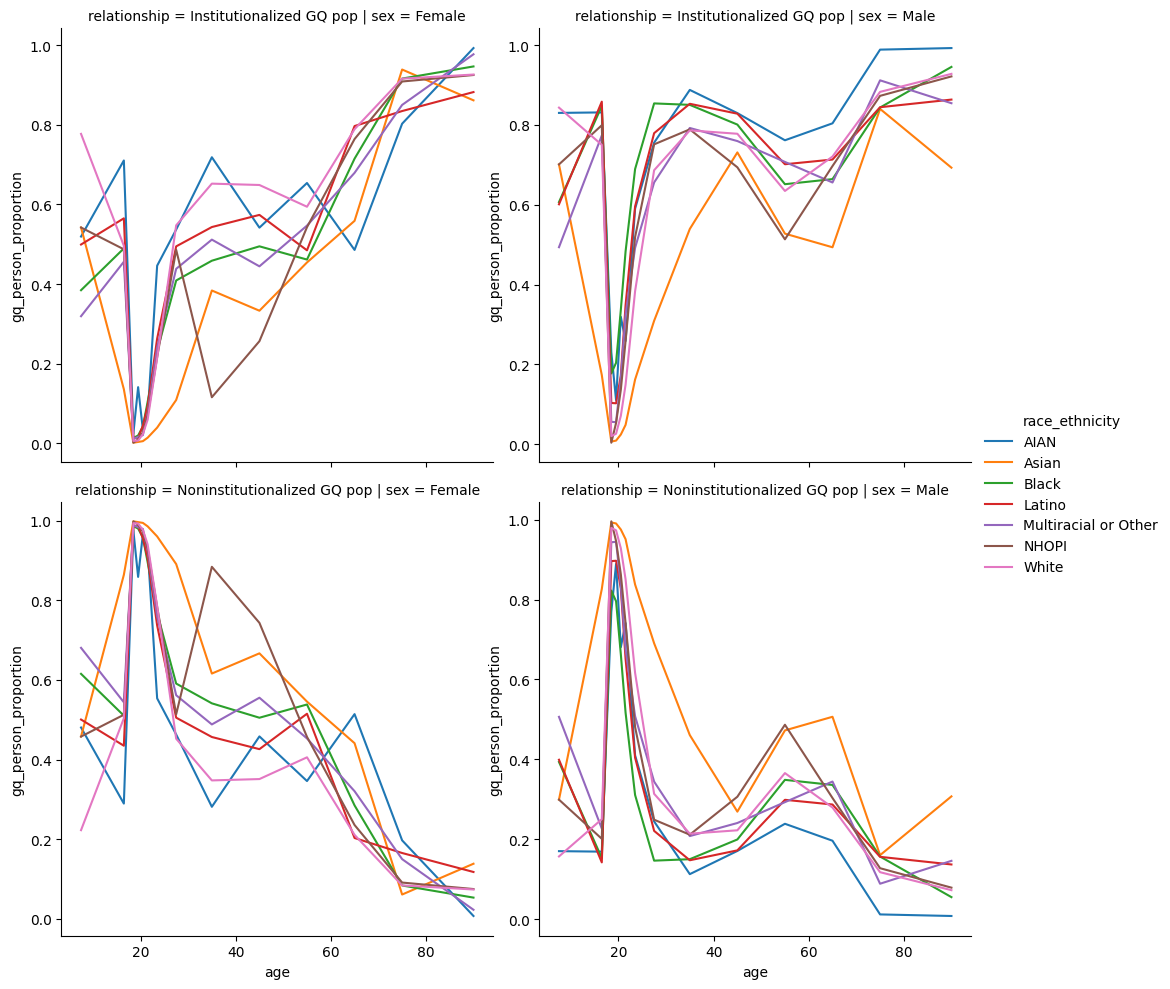

In [412]:
display_relationship_proportions(gq_relationship_proportions, 'gq_person_proportion')

In [165]:
format_relationship_proportions_for_file(gq_relationship_proportions, 'proportion').to_csv('sim_inputs/gq_person_move_relationship_proportions.csv')

### Non-reference person relationship

In [174]:
nrp_relationship_proportions, nrp_sample_size = fill_proportions_by_sample_size(acs[acs.move_type == 'non_reference_person'], ['age_group', 'sex', 'race_ethnicity'], ['relationship'], min_stratification_columns=1)
nrp_relationship_proportions

age_group  sex     race_ethnicity  relationship     
[0, 15)    Female  AIAN            Adopted child        0.006823
                                   Biological child     0.167427
                                   Child-in-law         0.000000
                                   Foster child         0.097839
                                   Grandchild           0.410253
                                   Opp-sex partner      0.000000
                                   Opp-sex spouse       0.000000
                                   Other nonrelative    0.110244
                                   Other relative       0.153501
                                   Parent               0.000000
                                                          ...   
[80, 100)  Male    White           Opp-sex spouse       0.121390
                                   Other nonrelative    0.102970
                                   Other relative       0.057886
                                   Pa

In [175]:
nrp_sample_size.groupby(['age_group', 'sex', 'race_ethnicity']).sum().sort_values()

age_group  sex     race_ethnicity
[80, 100)  Male    Latino             1155
[15, 18)   Female  Black              1172
[21, 22)   Female  Latino             1222
[15, 18)   Female  Latino             1318
[18, 19)   Female  Latino             1343
[20, 21)   Female  Latino             1376
[60, 70)   Male    Latino             1395
[50, 60)   Female  Asian              1401
[80, 100)  Male    Asian              1446
                   Black              1455
                                     ...  
[25, 30)   Male    White             18474
           Female  AIAN              18601
[0, 15)    Female  NHOPI             20671
[22, 25)   Male    NHOPI             21197
[0, 15)    Male    NHOPI             21793
[30, 40)   Female  NHOPI             22007
[22, 25)   Female  NHOPI             22368
[25, 30)   Female  NHOPI             25935
[30, 40)   Male    NHOPI             26043
[25, 30)   Male    NHOPI             28170
Length: 196, dtype: int64

In [176]:
len(nrp_relationship_proportions[nrp_relationship_proportions.isnull()])

0

In [177]:
len(nrp_relationship_proportions[nrp_relationship_proportions == np.inf])

0

In [178]:
len(nrp_relationship_proportions[nrp_relationship_proportions == 0])

490

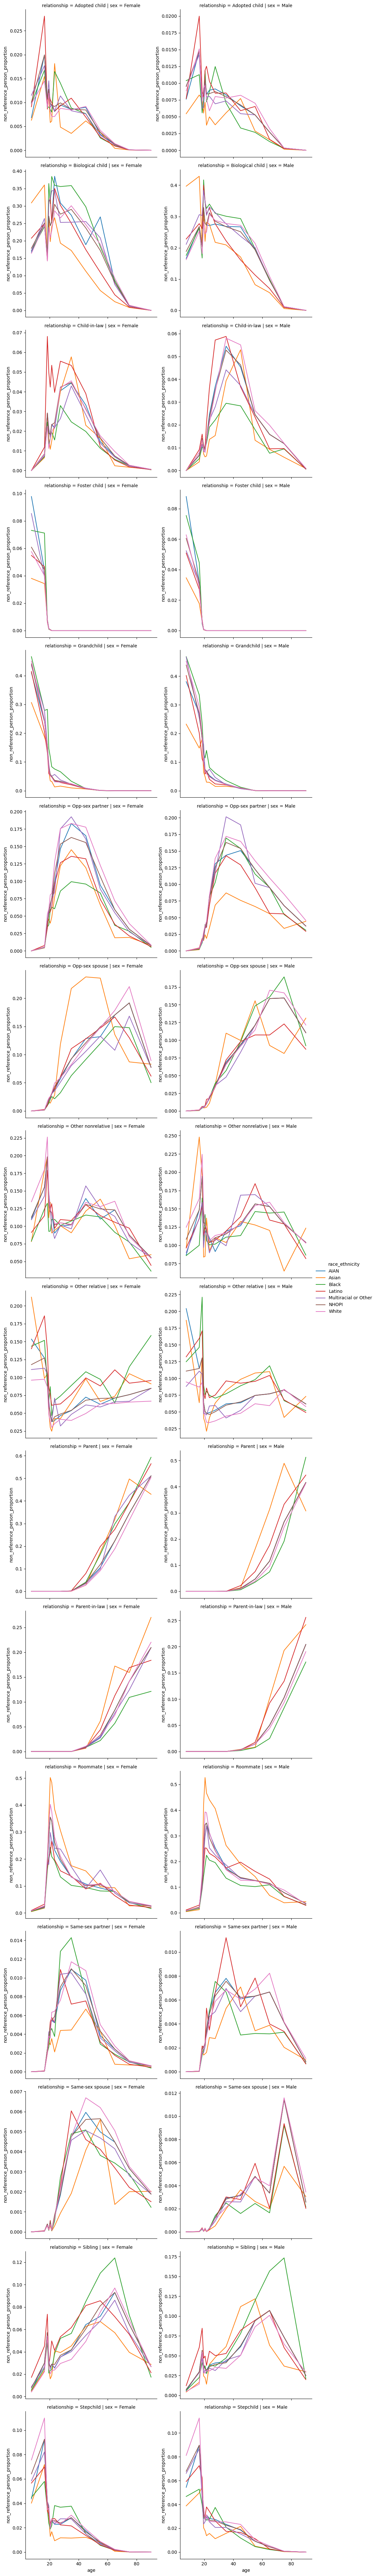

In [179]:
display_relationship_proportions(nrp_relationship_proportions, 'non_reference_person_proportion')

In [180]:
format_relationship_proportions_for_file(nrp_relationship_proportions, 'proportion').to_csv('sim_inputs/non_reference_person_move_relationship_proportions.csv')

## Location -> location flows
### MIGPUMA -> PUMA flows

In [128]:
puma_proportions, puma_sample_size = fill_proportions_by_sample_size(
    acs[acs.domestic_migrant]
        .assign(MIGSP=lambda x: x.MIGSP.astype(int).astype(str), MIGPUMA=lambda x: pd.Categorical(x.MIGSP.astype(int).astype(str) + '__' + x.MIGPUMA.astype(int).astype(str)))
        .assign(ST=lambda x: x.ST.astype(int).astype(str), PUMA=lambda x: pd.Categorical(x.ST.astype(int).astype(str) + '__' + x.PUMA.astype(int).astype(str)))
        .assign(dummy='foo'),
    ['dummy', 'MIGPUMA'],
    ['PUMA'],
    min_stratification_columns=1
)
puma_proportions

dummy  MIGPUMA  PUMA   
foo    10__100  10__101    0.181633
                10__102    0.117083
                10__103    0.214927
                10__104    0.124134
                10__200    0.037648
                10__300    0.022549
                11__101    0.000130
                11__102    0.000105
                11__103    0.000125
                11__104    0.000129
                             ...   
       9__900   9__306     0.000057
                9__500     0.011027
                9__700     0.019004
                9__900     0.065259
                9__901     0.087092
                9__902     0.108377
                9__903     0.068598
                9__904     0.074930
                9__905     0.149619
                9__906     0.078269
Name: PWGTP, Length: 2308682, dtype: float64

In [129]:
puma_sample_size.groupby(['MIGPUMA']).sum().sort_values()

MIGPUMA
6__3700      1821605
48__4600     1879093
17__3400     1882336
25__390      1884481
48__2300     1884531
6__5900      1890604
6__7300      1893988
6__8500      1894820
53__11600    1894859
6__100       1895365
              ...   
21__700      1930080
21__800      1930083
48__5600     1930087
22__1000     1930098
54__600      1930099
13__2700     1930100
55__1301     1930101
22__1100     1930104
22__1600     1930127
39__4900     1930128
Length: 982, dtype: int64

In [130]:
len(puma_proportions[puma_proportions.isnull()])

0

In [131]:
len(puma_proportions[puma_proportions == np.inf])

0

In [132]:
len(puma_proportions[puma_proportions == 0])

0

In [133]:
# Unpack values
puma_proportions = puma_proportions.reset_index()
puma_proportions[['ST', 'PUMA']] = puma_proportions.PUMA.str.split('__', expand=True).astype(int)
puma_proportions[['MIGSP', 'MIGPUMA']] = puma_proportions.MIGPUMA.str.split('__', expand=True).astype(int)
puma_proportions = puma_proportions.drop(columns=['dummy']).set_index(['MIGSP', 'MIGPUMA', 'ST', 'PUMA']).PWGTP.sort_index()
puma_proportions

MIGSP  MIGPUMA  ST  PUMA 
1      190      1   100      0.471866
                    200      0.000154
                    301      0.000155
                    302      0.000139
                    400      0.000069
                    500      0.000091
                    600      0.000104
                    700      0.000074
                    800      0.000103
                    900      0.000078
                               ...   
56     500      55  55102    0.000105
                    55103    0.000167
                    70101    0.000063
                    70201    0.000080
                    70301    0.000100
                56  100      0.000093
                    200      0.037008
                    300      0.000174
                    400      0.000076
                    500      0.717000
Name: PWGTP, Length: 2308682, dtype: float64

In [134]:
# Unpack sample size values
puma_sample_size = puma_sample_size.rename('sample_size').reset_index()
puma_sample_size[['ST', 'PUMA']] = puma_sample_size.PUMA.str.split('__', expand=True).astype(int)
puma_sample_size[['MIGSP', 'MIGPUMA']] = puma_sample_size.MIGPUMA.str.split('__', expand=True).astype(int)
puma_sample_size = puma_sample_size.drop(columns=['dummy']).set_index(['MIGSP', 'MIGPUMA', 'ST', 'PUMA']).sample_size.sort_index()
puma_sample_size

MIGSP  MIGPUMA  ST  PUMA 
1      190      1   100       709
                    200       837
                    301       774
                    302       999
                    400       632
                    500      1092
                    600       713
                    700       590
                    800       661
                    900       549
                             ... 
56     500      55  55102     924
                    55103    1037
                    70101     457
                    70201     458
                    70301     540
                56  100       712
                    200        33
                    300      1258
                    400       664
                    500       646
Name: sample_size, Length: 2308682, dtype: int64

### PUMA -> PUMA flows

Since MIGPUMA is the most granular we have about source, we simply repeat it for each corresponding source PUMA.

In [181]:
puma_to_migpuma = pd.read_hdf('../data/puma_to_migpuma.hdf', key='puma_to_migpuma')
puma_to_migpuma = (
    puma_to_migpuma[['MIGSP', 'MIGPUMA', 'ST', 'PUMA']]
        # Remove PR
        .pipe(lambda x: x[x.MIGSP != 72])
)
puma_to_migpuma

,MIGSP,MIGPUMA,ST,PUMA
0,1,190,1,100
1,1,290,1,200
2,1,290,1,301
3,1,290,1,302
4,1,400,1,400
5,1,290,1,500
6,1,600,1,600
7,1,700,1,700
8,1,800,1,800
9,1,900,1,900


In [182]:
len(puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size())

982

In [146]:
puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size().value_counts()

1     655
2     118
3      60
4      41
5      20
6      19
7      18
8      11
9       6
10      6
13      4
11      3
14      3
16      3
22      2
15      2
18      2
38      2
12      2
26      1
25      1
69      1
35      1
34      1
dtype: int64

In [185]:
puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size().value_counts().loc[1] / len(puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size())

0.6670061099796334

In [187]:
puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size().value_counts().loc[[1, 2]].sum() / len(puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size())

0.7871690427698574

In [188]:
puma_to_migpuma.groupby(['MIGSP', 'MIGPUMA']).size().mean()

2.394093686354379

In [190]:
puma_proportions

MIGSP  MIGPUMA  ST  PUMA 
1      190      1   100      0.471866
                    200      0.000154
                    301      0.000155
                    302      0.000139
                    400      0.000069
                    500      0.000091
                    600      0.000104
                    700      0.000074
                    800      0.000103
                    900      0.000078
                               ...   
56     500      55  55102    0.000105
                    55103    0.000167
                    70101    0.000063
                    70201    0.000080
                    70301    0.000100
                56  100      0.000093
                    200      0.037008
                    300      0.000174
                    400      0.000076
                    500      0.717000
Name: PWGTP, Length: 2308682, dtype: float64

In [191]:
flows_by_source_puma = expand_index_to(
        puma_proportions.reset_index().rename(columns={'ST': 'destination_ST', 'PUMA': 'destination_PUMA'}).set_index(['MIGSP', 'MIGPUMA', 'destination_ST', 'destination_PUMA']),
        pd.MultiIndex.from_frame(puma_to_migpuma),
    full_match=False
)
flows_by_source_puma

destination_ST  destination_PUMA     PWGTP
MIGSP MIGPUMA ST PUMA                                            
1     190     1  100                1               100  0.471866
                 100                1               200  0.000154
                 100                1               301  0.000155
                 100                1               302  0.000139
                 100                1               400  0.000069
                 100                1               500  0.000091
                 100                1               600  0.000104
                 100                1               700  0.000074
                 100                1               800  0.000103
                 100                1               900  0.000078
...                               ...               ...       ...
56    500     56 500               55             55102  0.000105
                 500               55             55103  0.000167
                 500               55             70101  0.000063
                 500               55             70201  0.000080
                 500               55             70301  0.000100
                 500               56               100  0.000093
                 500               56               200  0.037008
                 500               56               300  0.000174
                 500               56               400  0.000076
                 500               56               500  0.717000

[5527201 rows x 3 columns]

In [192]:
flows_by_source_puma = (
    flows_by_source_puma
        .reset_index()
        .set_index(['ST', 'PUMA', 'destination_ST', 'destination_PUMA'])
        .PWGTP.rename('proportion')
        .sort_index()
)
flows_by_source_puma

ST  PUMA  destination_ST  destination_PUMA
1   100   1               100                 0.471866
                          200                 0.000154
                          301                 0.000155
                          302                 0.000139
                          400                 0.000069
                          500                 0.000091
                          600                 0.000104
                          700                 0.000074
                          800                 0.000103
                          900                 0.000078
                                                ...   
56  500   55              55102               0.000105
                          55103               0.000167
                          70101               0.000063
                          70201               0.000080
                          70301               0.000100
          56              100                 0.000093
                      

In [ ]:
# TODO: Map some examples (flows from a single PUMA)

In [193]:
def format_puma_to_puma_flows_for_file(puma_to_puma_flows, name):
    if isinstance(puma_to_puma_flows, pd.Series):
        puma_to_puma_flows = puma_to_puma_flows.rename(name).reset_index()
    else:
        puma_to_puma_flows = puma_to_puma_flows.reset_index()
    return puma_to_puma_flows.rename(columns={'ST': 'state', 'PUMA': 'puma', 'destination_ST': 'destination_state', 'destination_PUMA': 'destination_puma'})

In [196]:
format_puma_to_puma_flows_for_file(flows_by_source_puma, 'proportion')

,state,puma,destination_state,destination_puma,proportion
0,1,100,1,100,0.471866
1,1,100,1,200,0.000154
2,1,100,1,301,0.000155
3,1,100,1,302,0.000139
4,1,100,1,400,0.000069
5,1,100,1,500,0.000091
6,1,100,1,600,0.000104
7,1,100,1,700,0.000074
8,1,100,1,800,0.000103
9,1,100,1,900,0.000078


In [197]:
format_puma_to_puma_flows_for_file(flows_by_source_puma, 'proportion').to_csv('/mnt/team/simulation_science/priv/users/zmbc/prl/puma_to_puma_proportions.csv')